# CAB420 Assignment 1B Question 2: Template

## Overview

This notebook provides a helper function to load in the Oxford-IIIT Pets dataset suitable for classification and semantic segmentation.

It also provides an example of how to load in the MobileNetV3Small Network which you are required to fine tune for the second part of the question.

Please read the comments and instructions within this notebook. It has been carefully designed to help you with many of the tasks required.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
from matplotlib import gridspec


import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation, Flatten
from tensorflow.keras.models import Model


import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image_dataset_from_directory
import keras
import glob


/home/ethan/miniconda3/envs/tf2.12/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading in the data

We first provide some helper functions to format the data in the way we need. You shouldn't need to change these, though you are welcome to if you like.


In [2]:
def mobilenet_preprocess_image(image):
    """Apply preprocessing that is suitable for MobileNetV3.
    
    Simply scales to ranges [-1, 1]
    
    
    you should use this preprocessing for both your model and the mobilenet model
    """
    image = (image - 127.5) / 255.0
    return image
    
    
def unprocess_image(image):
    """ undo preprocessing above so can plot images"""
    image = image * 255.0 + 127.5
    return image

In [3]:

def preprocess_and_resize(image, output, image_size):
    """apply preprocessing steps above to images and resize images and maps
    
    Each image in the dataset is of a different size. The resizing will make sure
    each image is the same size.
    """
    # resize the image and the semantic segmentation mask
    image = tf.image.resize(image, [image_size, image_size])
    image = mobilenet_preprocess_image(image)
    decoded_target = tf.image.resize(output[1], [image_size, image_size])
    decoded_target = mobilenet_preprocess_image(decoded_target)
    return image, (output[0], decoded_target)


We will now put this all together into a helper function. You can use this directly as is and should be fine to hit the ground running. However, you may modify it to add some additional functionality such as data augmentation if you like.

In [4]:
cifar_train_ds = tfds.load('cifar10', split='train')
cifar_test_ds = tfds.load('cifar10', split='test')

In [5]:
sample = next(iter(cifar_test_ds))
print(sample)

{'id': <tf.Tensor: shape=(), dtype=string, numpy=b'test_09933'>, 'image': <tf.Tensor: shape=(32, 32, 3), dtype=uint8, numpy=
array([[[180, 186, 189],
        [161, 167, 168],
        [140, 146, 142],
        ...,
        [ 52,  55,  40],
        [ 51,  55,  40],
        [ 51,  54,  40]],

       [[172, 178, 176],
        [150, 156, 153],
        [118, 125, 118],
        ...,
        [ 45,  47,  33],
        [ 43,  45,  31],
        [ 44,  48,  34]],

       [[161, 168, 160],
        [147, 155, 146],
        [120, 127, 118],
        ...,
        [ 42,  48,  33],
        [ 43,  50,  34],
        [ 46,  56,  39]],

       ...,

       [[249, 249, 249],
        [253, 253, 253],
        [252, 252, 252],
        ...,
        [254, 254, 254],
        [255, 255, 255],
        [251, 251, 251]],

       [[249, 249, 249],
        [253, 253, 253],
        [252, 252, 252],
        ...,
        [254, 254, 254],
        [255, 255, 255],
        [252, 252, 252]],

       [[249, 249, 249],
        [253

In [6]:
def image_label_image(x):
  """return original image, class label, and image"""
  image = x['image']
  label = x['label']
  return image, (label, image)



In [7]:
cifar_train_ds = cifar_train_ds.map(image_label_image)
cifar_test_ds = cifar_test_ds.map(image_label_image)



input_im, output_tuple = next(iter(cifar_train_ds))
print(input_im.shape)

In [8]:
input_im, output_tuple = next(iter(cifar_train_ds))
print(input_im.shape)
print(output_tuple[1].shape)

(32, 32, 3)
(32, 32, 3)


In [9]:
image_size = 120

cifar_train_ds = cifar_train_ds.map(lambda x, y: preprocess_and_resize(x, y, image_size))
cifar_test_ds = cifar_test_ds.map(lambda x, y: preprocess_and_resize(x, y, image_size))


In [10]:
# optional thing to speed up things slightly
#cifar_train_ds = cifar_train_ds.cache()
#cifar_test_ds = cifar_test_ds.cache()

In [11]:
!pip install tensorflow_addons

/usr/bin/fish: /home/ethan/miniconda3/envs/tf2.12/lib/libtinfo.so.6: no version information available (required by /usr/bin/fish)


In [12]:
import tensorflow_addons as tfa

/home/ethan/miniconda3/envs/tf2.12/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [13]:
def random_rotations(x, y, max_rotation=0.785398):
  """apply random rotations to predictor variable and my autoencoder target"""
  rot_val = tf.random.uniform((), minval=-max_rotation, maxval=max_rotation)
  image = tfa.image.rotate(x, rot_val, fill_mode='nearest')
  decoder_target = tfa.image.rotate(y[1], rot_val, fill_mode='nearest')
  return image, (y[0], decoder_target)


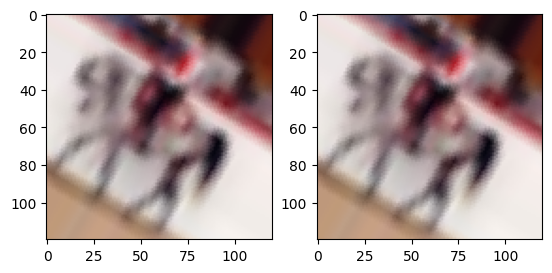

In [14]:
ds = cifar_train_ds.map(random_rotations)
x, y = next(iter(ds))
fig, axs = plt.subplots(1, 2)
axs[0].imshow(unprocess_image(x).numpy().astype(int))
axs[1].imshow(unprocess_image(y[1]).numpy().astype(int))

In [15]:
cifar_train_ds = cifar_train_ds.map(random_rotations)


Looks good, can ignore the JPEG data Warning.

In [16]:
batch_size = 16
cifar_train_ds = cifar_train_ds.shuffle(5000).batch(batch_size)
cifar_test_ds = cifar_test_ds.batch(batch_size)

# Loading MobileNetV3Small base for fine tuning

This model can be loaded directly from Tensorflow. By default, the model we download will be pre-trained on Imagenet dataset.

Note that we will need to set the preprocessing option when loading this base network to False.
    This is because the `include_preprocessing` step is implemented in the Datasets we defined above.

We also set `include_top=False`, to avoid loading our model with the final Dense classification layer which is used for the original Imagenet model.

In [17]:
mobile_base = keras.applications.MobileNetV3Small(input_shape=(image_size, image_size, 3),
                                                  include_top=False,
                                                  include_preprocessing=False)

For this task, can ignore the input_shape warning, though it is important to keep in mind the difference in size of data used for the pre-trained model and our data may have an impact on our model (what that impact might be is for you to investigate :) )

For more information on fine-tuning models, can refer to many of the examples from class, or the Keras documentation.

https://keras.io/guides/transfer_learning/


In [18]:
#mobile_base.summary()

In [19]:
mobile_base.trainable = False

#mobile_base.summary()

In [24]:
from tensorflow.keras import layers
# setting up base network / encoder to get embedding
inputs = layers.Input((image_size, image_size, 3))
embedding = mobile_base(inputs)

# classification output
flattened = layers.GlobalAveragePooling2D(name='gap')(embedding)
classification = layers.Dense(10, activation=None, name='classification')(flattened)

# decoder
x =  layers.UpSampling2D((3, 3))(embedding)
x =  layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x =  layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x =  layers.UpSampling2D((3, 3))(x)
x =  layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x =  layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x =  layers.UpSampling2D((3, 3))(x)
x =  layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x =  layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# output, 3 channels
x =  layers.Conv2D(3, (1, 1), activation=None, padding='same')(x)
decoded = keras.layers.Resizing(image_size, image_size)(x)

model = keras.Model(inputs, [classification, decoded])


In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3small (Functional)  (None, 4, 4, 576)    939120      ['input_2[0][0]']                
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 12, 12, 576)  0           ['MobilenetV3small[0][0]']       
                                                                                                  
 conv2d (Conv2D)                (None, 12, 12, 64)   331840      ['up_sampling2d[0][0]']      

In [25]:
model.compile(loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   keras.losses.MeanAbsoluteError()],
              optimizer='adam')

In [26]:
history = model.fit(cifar_train_ds,
          epochs=5,
          validation_data=cifar_test_ds,
          verbose=True)

Epoch 1/5
3125/3125 [==============================] - 59s 17ms/step - loss: 1.0768 - classification_loss: 0.9629 - resizing_1_loss: 0.1138 - val_loss: 0.8371 - val_classification_loss: 0.7262 - val_resizing_1_loss: 0.1109
Epoch 2/5
3125/3125 [==============================] - 55s 16ms/step - loss: 0.8924 - classification_loss: 0.7865 - resizing_1_loss: 0.1059 - val_loss: 0.7880 - val_classification_loss: 0.6793 - val_resizing_1_loss: 0.1086
Epoch 3/5
3125/3125 [==============================] - 55s 16ms/step - loss: 0.8670 - classification_loss: 0.7633 - resizing_1_loss: 0.1037 - val_loss: 0.7760 - val_classification_loss: 0.6690 - val_resizing_1_loss: 0.1070
Epoch 4/5
3125/3125 [==============================] - 56s 17ms/step - loss: 0.8469 - classification_loss: 0.7446 - resizing_1_loss: 0.1024 - val_loss: 0.7603 - val_classification_loss: 0.6510 - val_resizing_1_loss: 0.1093
Epoch 5/5
3125/3125 [==============================] - 56s 16ms/step - loss: 0.8392 - classification_loss: 0

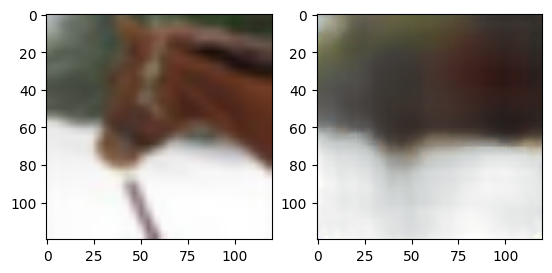

In [28]:
# lets plot a decoded sample to see how it looks
x, y = next(iter(cifar_test_ds))
classification, decoded = model(x)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(unprocess_image(tf.squeeze(x[0])).numpy().astype(int))
axs[1].imshow(unprocess_image(tf.squeeze(decoded[0])).numpy().astype(int))


In [ ]:
A bit of a blurry mess, but not too bad given the simplicity of the model, especia

What you would need to change for you assignment

1. Output dimensions
2. loss function

In [ ]:
from tensorflow.keras import layers
# setting up base network / encoder to get embedding
inputs = layers.Input((image_size, image_size, 3))
embedding = mobile_base(inputs)

# classification output
flattened = layers.GlobalAveragePooling2D(name='gap')(embedding)
classification = layers.Dense(10, activation=None, name='classification')(flattened)

# decoder
x =  layers.UpSampling2D((3, 3))(embedding)
x =  layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x =  layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x =  layers.UpSampling2D((3, 3))(x)
x =  layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x =  layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x =  layers.UpSampling2D((3, 3))(x)
x =  layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x =  layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)


# output - for binary semantic segmentation - one channel
x =  layers.Conv2D(1, (1, 1), activation=None, padding='same')(x)
decoded = keras.layers.Resizing(image_size, image_size)(x)

model = keras.Model(inputs, [classification, decoded])


## Loss function to change

Semnatic segmentation is essentially just pixel level classification. 
Make your loss function a classificaiton loss function (for the semantic segmentation decoder atleast)


### Loss functions to investigate

1. tf.keras.losses.BinaryCrossentropy -  https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy

2. tf.keras.losses.BinaryFocalCrossentropy - https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryFocalCrossentropy

This loss is designed specifically for segmentation tasks. There is a reference to the paper in this link you can follow for more info.